# Sensitivity analysis example

Below is an exampel fo conducting a sensitivity analysis on a simple model.  The model emplyed below is the simple fish-oxygen model we've seen before, but the pproach is the same regardless of the model.

The model examines fish production in a pond.  The model consists of two state variables, Fish (F) and Oxygen (O2) in the pond. The basic idea of the model is that Fish production in an aquaculture setting can be limited by available oxygen in the water column - at low oxygen levels, the per-capita mortality of Fish increases as oxygen levels in the pond decrease. 

We will calculate two sensitivity statistics, Relative Sensitivity and Absolute Sensitivity, defined as follows:

 
$\large Absolute Sensitivity = \frac {R_p-R_b}{P_p-P_b} $

$\large Relative Sensitivity = \frac {\frac {R_p-R_b}{R_b}} {\frac {P_p-P_b}{P_b}} $

where:
$ R_b $ is the base Response value

$ R_p $ is the perturbed Response value

$ P_b $ is the base Parameter value

$ P_b $ is the pertured Parameter value


You will want to run the model for **120 days**

** Sensitivy Analysis Parameters: **

Parameter | Definition | Base Value
--------- | ---------- | -----
`flowrate` | inflow rate to the pond | 2.0 L/L-day
`kO2` | Per-capita oxygen consumption rate | 0.0012 gO2/gFish-day
`O2in` | Oxygen level in pond influent | 0.008 g/L


### Step 1 - Create a function to run you model

success


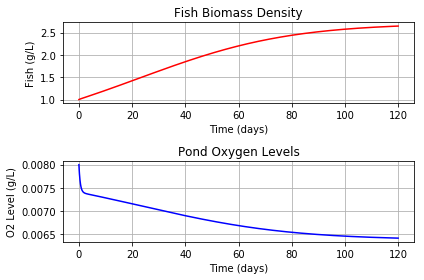

In [7]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# known model parameters.  Note: units are L, g, day
flowrate = 2.0   # L/L/day
kO2 = 0.0012     # gO2/gFish/ day
kGrowth = 0.05   # g/g/day
O2in = 0.008     # g/L
aeration = 0.0   # g/L/day
km = 470
FInit = 1
O2Init = 0.008

###### Fish/Oxygen model ######
def theModel(y,t):
    F = y[0]
    O2 = y[1]
    dF_dt  = kGrowth*F - np.exp(-km*O2) * F
    dO2_dt = flowrate*(O2in-O2) - (kO2*F) + aeration
    return [ dF_dt, dO2_dt]

# function to run the model
def runTheModel():
    times = np.arange(0, 120.1, 0.1)
    Y = odeint(theModel, [FInit, O2Init], times)
    return times, Y

times,Y = runTheModel()

# plot results - upper plot is regression, lower is state variables
F = Y[:,0]
O2 = Y[:,1]

print("success")
# lower plot - state variables through time
plt.subplot(2,1,1)
plt.plot(times, F, 'r-')
plt.grid()
plt.xlabel('Time (days)')
plt.ylabel( 'Fish (g/L)')
plt.title( 'Fish Biomass Density')
            
plt.subplot(2,1,2)            
plt.plot(times, O2, 'b-')
plt.grid()
plt.xlabel('Time (days)')
plt.ylabel( 'O2 Level (g/L)')
plt.title( 'Pond Oxygen Levels')

plt.tight_layout()
plt.show()

### Step 1. Perturb the system

We will perturb parameters selected for sensitivity analysis 10% and rerun the model. 

**Parameters**
We will use flowrate, kO2, and O2in as our sensitivity parameters

**Output**
Our Sensitivity response variable will be the level of Fish at the end of the run.

In [8]:
import pandas as pd

# store base case parameter values
flowrate_base = flowrate
kO2_base = kO2
O2in_base = O2in


# run the base case
times,Yb = runTheModel()
Fishb = Yb[-1,0]  # base case Fish biomass (first column) at end of run (last row)

print( 'Base case Response Value: {:.3}'.format(Fishb))

# calculate sensitivities for each parameter.  We will record these in a sequence
# that we will use later to populate a pandas dataframe (a convenient way to print tables)

# first, flowrate
flowrate = flowrate * 1.10    # perturb by 10 percent
times,Y = runTheModel()
flowrate = flowrate_base      # restore starting value after run

Fishp = Y[-1,0]   # perturbed response variable
absSensitivity = (Fishp-Fishb)/(0.10*flowrate)   # change in response/change in parameter
relSensitivity = ((Fishp-Fishb)/Fishb)/0.10
results_fr = ('flowrate',flowrate,flowrate*1.10,Fishp,absSensitivity,relSensitivity)  # store results in a sequence

# kO2 next
kO2 = kO2 * 1.10    # perturb by 10 percent
times,Y = runTheModel()
kO2 = kO2_base      # restore starting value after run

Fishp = Y[-1,0] # perturbed case
absSensitivity = (Fishp-Fishb)/(0.10*kO2)   
relSensitivity = ((Fishp-Fishb)/Fishb)/0.10
results_k = ('kO2',kO2,kO2*1.10,Fishp,absSensitivity,relSensitivity)

# O2in next
O2in = O2in * 1.10    # perturb by 10 percent
times,Y = runTheModel()
O2in = O2in_base      # restore starting value after run

Fishp = Y[-1,0] # perturbed case
absSensitivity = (Fishp-Fishb)/(0.10*O2in)   
relSensitivity = ((Fishp-Fishb)/Fishb)/0.10
results_o2 = ('O2in',O2in,O2in*1.10,Fishp,absSensitivity,relSensitivity)

# make a dataframe to hold the results
records = [ results_fr, results_k, results_o2 ]
labels = ['Parameter', 'Base Value', 'Perturbed Value', 'Response Value', 'Absolute Sensitivity', 'Relative Sensitivity']
df = pd.DataFrame.from_records(records, columns=labels)

df = df.sort_values(by=['Relative Sensitivity'],ascending=False)

df  # print it


Base case Response Value: 2.65


,Parameter,Base Value,Perturbed Value,Response Value,Absolute Sensitivity,Relative Sensitivity
2,O2in,0.0080,0.00880,4.016165,1712.129252,5.175602
0,flowrate,2.0000,2.20000,2.896494,1.250161,0.944779
1,kO2,0.0012,0.00132,2.416052,-1920.079535,-0.870632


#### From this, we can see that the O2in parameter is the most sensitive of the three parameters tested.

We can rank the parameters by the absolute value of the relative sensitivity - the highest absolute value of the relative sensitivities will be the parameter the model is most sensititive to. 